# Исследование надежности заемщиков.

### Описание проекта
Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Обзор данных

Посмотрим, общую информацию о таблице.

In [1]:
import pandas as pd
df = pd.read_csv('/datasets/data.csv')
df_reserv = pd.read_csv('/datasets/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Количество значений в колонках 1 и 10 отличается от общего числа строк.

In [2]:
display(df.sample(5))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
5153,0,-1175.219496,22,высшее,0,женат / замужем,0,F,сотрудник,0,248980.346070,операции с жильем
12266,1,NaN,26,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,покупка жилья для семьи
4760,0,-352.008504,31,высшее,0,Не женат / не замужем,4,F,компаньон,0,238322.371742,на покупку подержанного автомобиля
16146,0,-1704.682723,48,Среднее,1,женат / замужем,0,F,сотрудник,0,78733.333956,на покупку автомобиля
10622,0,385664.024835,67,среднее,1,женат / замужем,0,F,пенсионер,0,27776.117526,заняться образованием


Посмотрим на оригинальные значения в столбцах 'children', 'education', 'family_status', 'income_type', 'gender', 'purpose'.

In [3]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Количество детей - исследуемый параметр. Берём на заметку, что в нём есть невозможное значение -1 в 47 строках.

In [4]:
df['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75])

Ноль выбивается из значений.

In [5]:
print('Строк с нулевым значением возраста', df[df['dob_years'] == 0]['dob_years'].count(), 'штука.')

Строк с нулевым значением возраста 101 штука.


In [6]:
df['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

В столбце 'education' есть дублирующие значения. Проблема решится приведением всех значений к одному регистру.

In [7]:
df['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

Дублей нет, странных значений нет, со столбцом ничего делать не надо.

In [8]:
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

Значения выглядят нормальными.

In [9]:
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Одно значение какое-то странное. Посмотрим эту строку.

In [10]:
df[df['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,-2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


Поскольку нет апелляции к полу в поставленных вопросах и строка такая же, как остальные, не промежуточный итог или что-то выбивающееся из списка, оставим это значение без изменений.

In [11]:
df['purpose'].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
операции с жильем                         653
покупка жилья для сдачи                   653
операции с коммерческой недвижимостью     651
жилье                                     647
покупка жилья                             647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Все значения выглядят нормально.

### Шаг 2.1 Заполнение пропусков

Разберёмся со столбцом зарплат. 

Отсутствие данных по зарплате может говорить о нежелании клиента распространяться на эту тему, с другой стороны, уровень заработной платы влияет на одобрение кредита. Причина может быть ещё в том, что кредитополучатель сам не работает, а выплаты делает его/её партнёр. Или при выгрузке забыли указать необходимость предоставить эти данные, если датасет собирался в несколько заходов.

Посмотрим диапазон значений и медиану. Медиана показывает значение среднего элемента, меньше которого половина выборки и больше которого половина выборки. Смещение медианы к краю выборки показывает большую скученность значений в этой области значений. 

In [12]:
df['total_income'].min()  # минимальное

20667.26379327158

In [13]:
df['total_income'].max()  # максимальное

2265604.028722744

In [14]:
df['total_income'].median()  # медиана

145017.93753253992

Значение медианы гораздо ближе к минимальному, чем к максимальному значениям. Значит, большие значения могут быть единичными, и лучше использовать медиану, а не среднее арифметическое, для заполнения пропусков.

Всего пропусков в столбце входящих выплат сейчас столько:

In [15]:
df['total_income'].isna().sum()

2174

Заполним пропуски медианой

In [16]:
df['total_income'] = df['total_income'].fillna(145017.93753253992)
df['total_income'].isna().sum()

0

Теперь приведём этот столбец к целочисленному типу.

In [17]:
df['total_income'] = df['total_income'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  int64  
 11  purpose           21525 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


### Шаг 2.2 Проверка данных на аномалии и исправления.

В столбце 'days_employed' видим странные значения для количества дней.

In [18]:
df['days_employed'].head(10)

0     -8437.673028
1     -4024.803754
2     -5623.422610
3     -4124.747207
4    340266.072047
5      -926.185831
6     -2879.202052
7      -152.779569
8     -6929.865299
9     -2188.756445
Name: days_employed, dtype: float64

Посмотрим, как связаны положительные и отрицательные значения с категориями занятости. 340266 дней занятости не может быть у нормального человека, это тысяча лет без малого.

In [19]:
df.loc[df['days_employed']>0]['income_type'].value_counts() # условно назовём это группа А

пенсионер      3443
безработный       2
Name: income_type, dtype: int64

In [20]:
df.loc[df['days_employed']<0]['income_type'].value_counts()  # а это группа Б

сотрудник          10014
компаньон           4577
госслужащий         1312
в декрете              1
предприниматель        1
студент                1
Name: income_type, dtype: int64

По какой-то причине количество дней занятости стало отрицательным в работающих категориях.
Оба типа значений не похожи на настоящие, скорее всего, не являются случайными и требуют уточнения своей природы у источника данных.

Выясним, как распределены пропуски в днях по категориям занятости.

In [21]:
df.loc[df['days_employed'].isna()]['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

Найдём медиану для пенсионеров, поскольку они одни в группе А по типу значений в днях занятости, их будет проще выделить, и заполним ею пропуски для пенсионеров.

In [22]:
median_a = df.loc[df['income_type'] == 'пенсионер']['days_employed'].median()
print('Медиана для пенсионеров:', median_a)
df.loc[df['income_type'] == 'пенсионер'] = df.loc[df['income_type'] == 'пенсионер'].fillna(median_a)
df.loc[df['days_employed'].isna()]['income_type'].value_counts()

Медиана для пенсионеров: 365213.3062657312


сотрудник          1105
компаньон           508
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

Остальные пропуски заполним медианой для группы Б.

In [23]:
median_b = df.loc[df['days_employed']<0]['days_employed'].median()
print('Медиана для оставшихся пропусков:', median_b)
df['days_employed'] = df['days_employed'].fillna(median_b)
print('Пропусков осталось:', df.loc[df['days_employed'].isna()]['income_type'].count())

Медиана для оставшихся пропусков: -1630.0193809778218
Пропусков осталось: 0


Теперь поступим следующим образом - отрицательные значения переведём в положительные и остановимся. Для дальнейшего анализа эти данные нам не понадобятся, поэтому достаточно привести их в более правдоподобный вид, что мы и сделали.

In [24]:
df.loc[df['days_employed']<0,'days_employed'] *= (-1)
print('Значений меньше нуля осталось:', df.loc[df['days_employed']<0]['days_employed'].count())
display(df.sample(5))

Значений меньше нуля осталось: 0


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
5541,2,1506.456938,33,начальное,3,женат / замужем,0,F,компаньон,0,260288,строительство жилой недвижимости
18236,0,206.315544,30,среднее,1,Не женат / не замужем,4,F,сотрудник,0,114831,получение образования
9118,0,1630.019381,45,среднее,1,женат / замужем,0,F,сотрудник,0,145017,строительство жилой недвижимости
18066,0,3555.618404,47,среднее,1,гражданский брак,1,F,компаньон,0,121914,дополнительное образование
18528,2,448.322148,41,среднее,1,женат / замужем,0,M,сотрудник,0,105109,покупка жилья для сдачи


Приступим к детям.

In [25]:
children_data = df[df['children'] != -1]
children_data['family_status'].value_counts()

женат / замужем          12351
гражданский брак          4172
Не женат / не замужем     2808
в разводе                 1191
вдовец / вдова             956
Name: family_status, dtype: int64

In [26]:
minus_children_data = df[df['children'] == -1]
minus_children_data['family_status'].value_counts()

женат / замужем          29
гражданский брак          5
Не женат / не замужем     5
в разводе                 4
вдовец / вдова            4
Name: family_status, dtype: int64

Непонятно, что имелось ввиду под '-1', строк с таким значением 4700/21525=0,22%, что меньше рекомендованного 1%, поэтому удалим эти строки из выборки.

In [27]:
df = df[df['children'] != -1]
df['children'].value_counts()

0     14149
1      4818
2      2055
3       330
20       76
4        41
5         9
Name: children, dtype: int64

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21478 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21478 non-null  int64  
 1   days_employed     21478 non-null  float64
 2   dob_years         21478 non-null  int64  
 3   education         21478 non-null  object 
 4   education_id      21478 non-null  int64  
 5   family_status     21478 non-null  object 
 6   family_status_id  21478 non-null  int64  
 7   gender            21478 non-null  object 
 8   income_type       21478 non-null  object 
 9   debt              21478 non-null  int64  
 10  total_income      21478 non-null  int64  
 11  purpose           21478 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.1+ MB


Ещё был возраст 0 лет. Заменим его медианой.

In [29]:
df['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75])

In [30]:
df['dob_years'].median()

42.0

In [31]:
df['dob_years'] = df['dob_years'].replace(0, 42)

In [32]:
df['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51, 59, 29, 60, 55, 58, 71, 22, 73, 66,
       69, 19, 72, 70, 74, 75])

### Шаг 2.4. Удаление дубликатов.

Посмотрим, какое количество явных дублей присутствует в таблице.

In [33]:
df.duplicated().sum()

55

Удалим их и обновим индексацию.

In [34]:
df = df.drop_duplicates().reset_index(drop=True)


Теперь вспомним, что при знакомствее с таблицей мы обнаружили в столбце с образованием одинаковые значения, записанные разным регистром. Приведём их к одному регистру и посмотрим, сколько ещё дублей удастся таким образом найти.

In [35]:
df['education'] = df['education'].str.lower()
df['education'].value_counts()

среднее                15150
высшее                  5242
неоконченное высшее      743
начальное                282
ученая степень             6
Name: education, dtype: int64

In [36]:
df.duplicated().sum()

17

Удалим и их.

In [37]:

df = df.drop_duplicates().reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21406 entries, 0 to 21405
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21406 non-null  int64  
 1   days_employed     21406 non-null  float64
 2   dob_years         21406 non-null  int64  
 3   education         21406 non-null  object 
 4   education_id      21406 non-null  int64  
 5   family_status     21406 non-null  object 
 6   family_status_id  21406 non-null  int64  
 7   gender            21406 non-null  object 
 8   income_type       21406 non-null  object 
 9   debt              21406 non-null  int64  
 10  total_income      21406 non-null  int64  
 11  purpose           21406 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

Теперь создадим словари для образования и семейного статуса.

In [38]:
df.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

Образование:

In [39]:
education_df = df[['education_id', 'education']]
display(education_df)

,education_id,education
0,0,высшее
1,1,среднее
2,1,среднее
3,1,среднее
4,1,среднее
...,...,...
21401,1,среднее
21402,1,среднее
21403,1,среднее
21404,1,среднее


In [40]:
education_df = education_df.drop_duplicates().reset_index(drop=True)
display(education_df)

,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


Семейный статус:

In [41]:
family_status_df = df[['family_status_id', 'family_status']]
family_status_df = family_status_df.drop_duplicates().reset_index(drop=True)
display(family_status_df)

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


In [42]:
print('Before deleting columns:')
print(df.columns)
df = df.drop(columns=['family_status', 'education'])
print('After deleting columns:')
df.columns

Before deleting columns:
Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')
After deleting columns:


Index(['children', 'days_employed', 'dob_years', 'education_id',
       'family_status_id', 'gender', 'income_type', 'debt', 'total_income',
       'purpose'],
      dtype='object')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21406 entries, 0 to 21405
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21406 non-null  int64  
 1   days_employed     21406 non-null  float64
 2   dob_years         21406 non-null  int64  
 3   education_id      21406 non-null  int64  
 4   family_status_id  21406 non-null  int64  
 5   gender            21406 non-null  object 
 6   income_type       21406 non-null  object 
 7   debt              21406 non-null  int64  
 8   total_income      21406 non-null  int64  
 9   purpose           21406 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 1.6+ MB


In [44]:
display(df.sample(10))

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
21383,1,1630.019381,42,1,0,F,сотрудник,0,145017,строительство жилой недвижимости
19876,0,165.962325,56,0,3,F,сотрудник,0,124544,жилье
3052,0,1158.649207,31,1,1,F,сотрудник,0,117783,свадьба
7955,2,1630.019381,38,1,1,M,компаньон,0,145017,на проведение свадьбы
19294,0,361819.105096,54,1,1,F,пенсионер,0,113178,на проведение свадьбы
14284,1,1630.019381,45,1,1,F,сотрудник,0,145017,на проведение свадьбы
6970,0,4728.364121,38,1,1,F,сотрудник,1,179521,на проведение свадьбы
17240,1,419.515459,34,1,0,F,сотрудник,0,59988,покупка недвижимости
17577,1,882.382060,25,1,0,F,сотрудник,1,172061,заняться высшим образованием
17061,1,3126.486056,31,0,0,F,сотрудник,0,81054,операции с недвижимостью


### Шаг 2.6. Категоризация дохода.

Распределим доход по категориям:
* 0       - 30000   Е
* 30001   - 50000   D
* 50001   - 200000  C
* 201000  - 1000000 B
* 1000001 и выше    А
    
Для этого напишем функцию.
    

In [45]:
def category_income(income):

    if income > 0 and income <= 30000:
        return 'E'
    if income <= 50000:
        return 'D'
    if income <= 200000:
        return 'C'
    if income <= 1000000:
        return 'B'
    else:
        return 'A'


In [46]:
df['total_income_category'] = df['total_income'].apply(category_income)

In [47]:
display(df.sample(10))

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
16715,1,1440.877105,39,1,1,F,компаньон,0,139219,строительство жилой недвижимости,C
2807,0,865.002968,53,1,1,M,сотрудник,0,96090,сыграть свадьбу,C
10241,0,345759.794669,58,1,1,F,пенсионер,0,110879,на покупку автомобиля,C
15190,1,189.361998,38,1,0,F,сотрудник,0,144360,покупка коммерческой недвижимости,C
21331,0,353581.883314,67,1,0,F,пенсионер,0,91630,недвижимость,C
21398,0,404.679034,42,0,1,F,компаньон,0,178059,на покупку своего автомобиля,C
9854,2,3336.911681,36,0,0,M,компаньон,0,590384,высшее образование,B
8548,1,1552.079617,37,1,0,M,компаньон,0,182866,операции с недвижимостью,C
20636,0,489.531421,58,1,4,F,сотрудник,0,165691,покупка жилья для сдачи,C
12005,1,2229.040556,32,0,0,F,сотрудник,0,143369,образование,C


### Шаг 2.7. Категоризация целей кредита.

Также при просмотре таблицы мы обнаружили, что цели кредита встречаются одинаковые, но сформулированные поразному.

In [48]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Сгруппируем их следующим образом:


* 'проведение свадьбы' : 
        свадьба, на проведение свадьбы, сыграть свадьбу

* 'операции с недвижимостью': 
        операции с недвижимостью, недвижимость, операции со своей недвижимостью, 
        покупка недвижимости, строительство собственной недвижимости, строительство недвижимости, 
        операции с коммерческой недвижимостью, покупка коммерческой недвижимости, операции с жильем,
        жилье,  ремонт жилью, покупка жилья для сдачи, покупка жилья, покупка жилья для семьи,
        покупка своего жилья, покупка жилой недвижимости, строительство жилой недвижимости

* 'операции с автомобилем': 
        автомобиль, автомобили, сделка с автомобилем, на покупку своего автомобиля,
        на покупку автомобиля, приобретение автомобиля, свой автомобиль, 
        сделка с подержанным автомобилем, на покупку подержанного автомобиля

* 'получение образования': 
        образование, получение образования, заняться образованием,
        заняться высшим образованием, высшее образование, получение высшего образования,
        дополнительное образование, получение дополнительного образования, профильное образование



In [49]:
def get_key(word):
    all_dict = { 
    'проведение свадьбы': ['свадьба', 'на проведение свадьбы', 'сыграть свадьбу'],
    'операции с недвижимостью': ['операции с недвижимостью', 'недвижимость', 'операции со своей недвижимостью', 'покупка недвижимости', 'строительство собственной недвижимости', 'строительство недвижимости', 'операции с коммерческой недвижимостью', 'покупка коммерческой недвижимости', 'операции с жильем', 'жилье', 'ремонт жилью','покупка жилья для сдачи', 'покупка жилья', 'покупка жилья для семьи', 'покупка своего жилья', 'покупка жилой недвижимости', 'строительство жилой недвижимости'],
    'операции с автомобилем': ['автомобиль', 'автомобили', 'сделка с автомобилем', 'на покупку своего автомобиля', 'на покупку автомобиля', 'приобретение автомобиля', 'свой автомобиль', 'сделка с подержанным автомобилем', 'на покупку подержанного автомобиля'],
    'получение образования': ['образование', 'получение образования', 'заняться образованием', 'заняться высшим образованием', 'высшее образование', 'получение высшего образования', 'дополнительное образование', 'получение дополнительного образования', 'профильное образование']
           }
    
    for item in all_dict.items():
        if word in item[1]:
            return item[0]
        


Применим эту функцию к столбцу с целью и создадим по результатам стобец с категориями назначения кредита.

In [50]:
df['purpose_category'] = df['purpose'].apply(get_key)
df.sample(10)

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
19100,0,4523.025618,40,1,0,F,сотрудник,0,109112,покупка жилой недвижимости,C,операции с недвижимостью
15123,0,401556.753550,68,0,1,F,пенсионер,0,231820,свадьба,B,проведение свадьбы
17310,0,353630.280094,64,1,3,F,пенсионер,0,305552,автомобили,B,операции с автомобилем
5550,1,2917.701025,52,2,1,F,сотрудник,1,200065,операции со своей недвижимостью,B,операции с недвижимостью
11934,1,245.303228,41,1,0,M,компаньон,1,64110,автомобили,C,операции с автомобилем
1198,0,788.099826,49,1,0,F,сотрудник,0,201270,строительство собственной недвижимости,B,операции с недвижимостью
14630,0,372846.154365,62,1,0,F,пенсионер,0,286471,строительство жилой недвижимости,B,операции с недвижимостью
944,0,2215.795751,35,1,1,M,сотрудник,0,209263,свадьба,B,проведение свадьбы
20438,1,2635.891154,32,1,0,F,сотрудник,0,70582,жилье,C,операции с недвижимостью
6179,20,1630.019381,35,0,4,M,компаньон,0,145017,жилье,C,операции с недвижимостью


### Ответы на вопросы.

##### Вопрос 1:

**Есть ли зависимость между количеством детей и возвратом кредита в срок**

In [51]:
children_debt = df.groupby('children')['debt'].sum()
children_debt

children
0     1063
1      444
2      194
3       27
4        4
5        0
20       8
Name: debt, dtype: int64

In [52]:
children_all = df.groupby('children')['debt'].count()
children_all

children
0     14090
1      4808
2      2052
3       330
4        41
5         9
20       76
Name: debt, dtype: int64

In [53]:
children_debt_conversion = children_debt * 100 / children_all
children_debt_conversion.sort_values()    # считаем конверсию - процент задолженностей в общем количестве кредитов

children
5      0.000000
0      7.544358
3      8.181818
1      9.234609
2      9.454191
4      9.756098
20    10.526316
Name: debt, dtype: float64

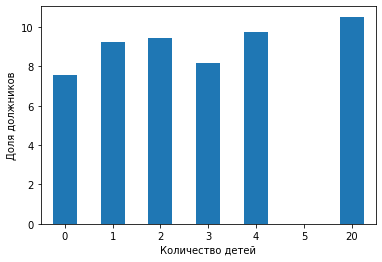

In [72]:
ax = children_debt_conversion.plot.bar(x='children', y='%', rot=0)
ax.set_ylabel('Доля должников')
ax.set_xlabel('Количество детей');

##### Вывод 1:

Количество задолженностей по кредиту колеблется от 7,5 до 10,5%, вероятней всего кредит отдадут те, у кого нет детей или их трое, вероятнее не отдадут те, у кого 20 детей. Для родителей 1, 2 и 4 разницы особой нет, задолженность будет в районе 9,5 % у всех. Про кредиторов с пятью детьми надо собрать больше информации, потому что значение сильно отличается от общей тенденции.

##### Вопрос 2:

**Есть ли зависимость между семейным положением и возвратом кредита в срок?**

In [55]:
family_debt = df.groupby('family_status_id')['debt'].sum()
family_debt

family_status_id
0    930
1    388
2     63
3     85
4    274
Name: debt, dtype: int64

In [56]:
family_status_debt = family_status_df.copy(deep=True)
family_all = df.groupby('family_status_id')['debt'].count()
family_status_debt['conversion'] = family_debt * 100 / family_all
family_status_debt.sort_values(by='conversion')

,family_status_id,family_status,conversion
2,2,вдовец / вдова,6.596859
3,3,в разводе,7.136860
0,0,женат / замужем,7.554833
1,1,гражданский брак,9.360676
4,4,Не женат / не замужем,9.768271


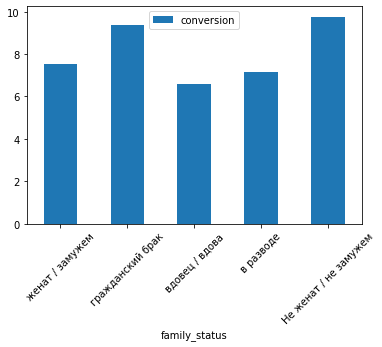

In [57]:
ax = family_status_debt.plot.bar(x='family_status', y='conversion', rot=45)

##### Вывод 2:

Наблюдается разброс значений от 6,5 до 9,7 %. Реже всех в должниках ходят вдовцы, средняя категория - в разводе и женатые, а чаще задерживают выплаты свободные граждане.

##### Вопрос 3:

**Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

In [58]:
total_income_debt = df.groupby('total_income_category')['debt'].sum()
total_income_debt

total_income_category
A       2
B     356
C    1359
D      21
E       2
Name: debt, dtype: int64

In [59]:
total_income_debt_all = df.groupby('total_income_category')['debt'].count()
total_income_debt_all

total_income_category
A       25
B     5033
C    15977
D      349
E       22
Name: debt, dtype: int64

In [60]:
total_income_debt_conversion = total_income_debt*100/total_income_debt_all
total_income_debt_conversion.sort_values()

total_income_category
D    6.017192
B    7.073316
A    8.000000
C    8.505977
E    9.090909
Name: debt, dtype: float64

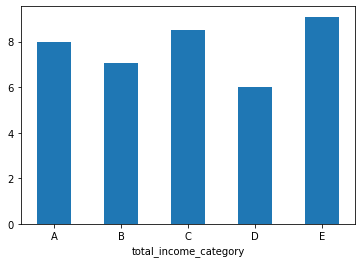

In [61]:
ax = total_income_debt_conversion.plot.bar(x='total_income_category', y='%', rot=0)

##### Вывод 3:

Разброс значений от 6 до 9%. Вероятнее всего задолжают кредиторы с доходом ниже 30000 р. Удивляет средний класс С и самые состоятельные люди, которые не сильно отстают от самых бедных и задерживают выплаты по кредитам. Самые благонадёжные кредиторы - с доходом в диапазоне 30-60 тысяч рублей (?рублей?).

##### Вопрос 4:

**Как разные цели кредита влияют на его возврат в срок?**

In [62]:
purpose_category_debt = df.groupby('purpose_category')['debt'].sum()
purpose_category_debt

purpose_category
операции с автомобилем      402
операции с недвижимостью    782
получение образования       370
проведение свадьбы          186
Name: debt, dtype: int64

In [63]:
purpose_category_debt_all = df.groupby('purpose_category')['debt'].count()
purpose_category_debt_all

purpose_category
операции с автомобилем       4295
операции с недвижимостью    10787
получение образования        4003
проведение свадьбы           2321
Name: debt, dtype: int64

In [64]:
purpose_category_debt_conversion = purpose_category_debt*100/purpose_category_debt_all
purpose_category_debt_conversion.sort_values()

purpose_category
операции с недвижимостью    7.249467
проведение свадьбы          8.013787
получение образования       9.243068
операции с автомобилем      9.359721
Name: debt, dtype: float64

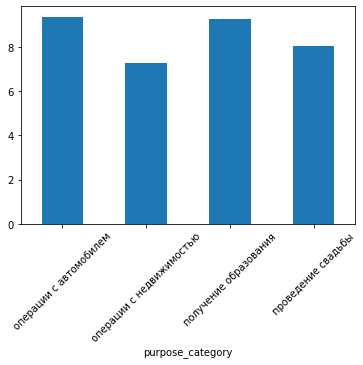

In [65]:
ax = purpose_category_debt_conversion.plot.bar(x='purpose_category',  rot=45)

##### Вывод 4:

Разброс значений от 7,2 до 9,3%. Задолженности чаще случаются по кредитам на автомобиль и образование, а на недвижимость - реже всего.

## Общий вывод:

Мы видим, что разница между категориями, какие бы ни взяли, составляет 2-3 %. Mожно говорить о зависимостях между задолженностью по кредиту и предложенными к рассмотрению параметрами.
Лучший заёмщик, который скорее всего будет вносить оплату по кредиту в срок, это бездетный вдовец с доходом ниже 30000 рублей, решивший купить квартиру. Многодетная (4 или 20 детей) одинокая мать с доходом от 30 до 50 тысяч рублей, решившая купить автомобиль, будет чаще других задерживать выплаты.